# Areas of Outstanding Natural Beauty (AONBs) Land Management Schemes

# Introduction¶
This is a reproducible data dictionary based on a python script to scrape Natural England open data in order to perform analysis for AONB areas. As this is a script, it can be re-run as and when the data is updated. Moreover, this analysis is reproducible meaning this analysis can be copied or investigated and improved on. For further details contact;

david.alexander@peakdistrict.gov.uk

The area managed under agri-environment agreements: ie the total area under Environmental Stewardship (ES), Countryside Stewardship (CS) (including its different levels).

#### Environmental Stewardship (ES)¶
ES is an agri-environment scheme which provides funding to farmers and other land managers in England who deliver effective environmental management on their land.

It has four elements:

* Entry Level Stewardship (ELS)
* Organic Entry Level Stewardship (OELS)
* Uplands Entry Level Stewardship (Uplands ELS)
* Higher Level Stewardship (HLS).

Upland ELS can apply to any agreement with an ELS or OELS component and therefore their figures are subsumed in the ELS, ELS/HLS, OELS and OELS/HLS categories.Data available:

1. Environmental Stewardship Scheme (England) holdings agreement polygons (includes farm business and payment info).

2. Environmental Stewardship Scheme (England) options points derived from Genesis tables.

#### Countryside Stewardship (CS)
CS is an agri-environment scheme with Higher Tier, full Mid tier, Mid Tier wildlife packages and Hedgerows and Boundaries grant schemes. Data available:

1. Countryside Stewardship Scheme 2016-2020 Management Areas geographic extent and location of all land under management within the Countryside Stewardship Agri-Environment Scheme.

2. Countryside Stewardship Scheme Agreements holding boundaries data.

3. Countryside Stewardship Scheme Agreement Option points.

# Analysis

#### Manage the GIS

In [18]:
from arcgis import GIS
from arcgis.features.manage_data import extract_data
import arcpy
import os
import numpy as np
from matplotlib import pyplot as plt
gis = GIS("Pro")
print(gis)

GIS @ https://www.arcgis.com/ version:8.4


In [2]:
# setup the environment
arcpy.env.addOutputsToMap = True
arcpy.env.overwriteOutput = True
arcpy.env.workspace = '~/ArcGIS/Projects/AONB/data/'
outgdb = '~/ArcGIS/Projects/AONB/AONB.gdb'

#### Data used in this analysis

Use the ESRI [living Atlas](https://livingatlas.arcgis.com/en/home/) layers as the sources of data

In [4]:
# find the data
CS_item = gis.content.get('b63046f37b5d4869b47ed16d4e23a168')
ES_item = gis.content.get('ca68c90958c342a285d6370ddd7edd66')
AONB_item = gis.content.get('6f2ad07d91304ad79cdecd52489d5046')

<Item title:"Countryside Stewardship Scheme 2016 Management Areas (England)" type:Feature Layer Collection owner:Opendata_NE>
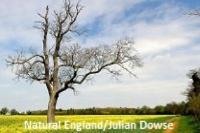

<Item title:"Environmental Stewardship Scheme Agreements (England)" type:Feature Layer Collection owner:Opendata_NE>
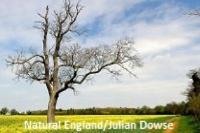

<Item title:"Areas of Outstanding Natural Beauty (England)" type:Feature Layer Collection owner:Opendata_NE>
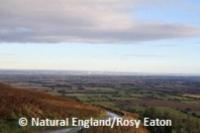

In [5]:
# display the ietems
data = [CS_item, ES_item, AONB_item]
for item in data:
    display(item)

In [14]:
# download the data 
CS_layer = extract_data([CS_item], data_format = 'Shapefile')
CS_layer.download('~/ArcGIS/Projects/AONB/data')
ES_gbd = extract_data([ES_item], data_format = 'Shapefile')
ES_gbd.download()
AONB_gbd = extract_data([AONB_item], data_format = 'Shapefile')
AONB_gbd.download()

In [15]:
# add the data to the geodatabase
fcs = arcpy.ListFeatureClasses()
for fc in fcs:
    desc = arcpy.da.Describe(fc)
    outfc = os.path.join(outgdb, desc["baseName"])
    arcpy.CopyFeatures_management(fc, outfc)

# Data pre-processing¶
1. Re-set the WS env & Clip the data to AONB boundaries
2. Call **geopandas** to create a df and use **Pandas** for data processing.
3. Create a new column **[END_YEAR]** and extract the calendar year from **[ENDDATE]** in the dataframe
4. Create a new column **[AREA_CLIP]** using the clipped geometry and add the calculated area (as data has been clipped some agreements overlap the boundary). This new column shows the area (sqkm) just inside the National Parks boundary.
5. **Sjoin** the NPE data to the ES and CS data so the data can be analysed collectively and individually for all NP's

In [16]:
# Re-set the WS env & Clip the data to AONB boundaries


# Switch the workspace to the geodatabse
arcpy.env.workspace = '~/ArcGIS/Projects/AONB/AONB.gdb'
# Clip the data to National Park England
arcpy.Clip_analysis("Environmental_Stewardship_Scheme_Agreements__England____Natural_England", "Areas_of_Outstanding_Natural_Beauty__England____Natural_England", "ES_clip")
arcpy.Clip_analysis("Countryside_Stewardship_Scheme_Management_Areas__England____Natural_England", "Areas_of_Outstanding_Natural_Beauty__England____Natural_England", "CS_clip")

<Result 'C:/Users/david/Documents/ArcGIS/Projects/AONB/AONB.gdb\\CS_clip'>

In [9]:
# import pandas :)
import pandas as pd
import geopandas as gpd

In [15]:
# create a geopandas data frame for AONB
AONB_gdf = gpd.read_file("~/ArcGIS/Projects/AONB/AONB.gdb/", layer = "Areas_of_Outstanding_Natural_Beauty__England____Natural_England")

#### Envirobmental Stewardship

In [16]:
# create a geopandas data frame
ES_clip_gdf = gpd.read_file("~/ArcGIS/Projects/AONB/AONB.gdb/", layer = "ES_clip")
# create the [END_YEAR] column
ES_clip_gdf['END_YEAR'] = pd.DatetimeIndex(ES_clip_gdf['ENDDATE']).year
# create the [AREA] column
ES_clip_gdf['AREA_CLIP'] = ES_clip_gdf['geometry'].area/10**6
# create a spatial join and append the AONB to the left of the gpd
ES_clip_gdf = gpd.sjoin(AONB_gdf, ES_clip_gdf, how="inner", op="intersects")
# take a look at the first 2 rows of the df to check :)
ES_clip_gdf.head(2)

,OBJECTID,CODE,NAME,DESIG_DATE,HOTLINK,STAT_AREA,SHAPE_Leng_left,Shape_Length_left,Shape_Area_left,geometry,index_right,FID_1,AGREF,CPH,CUSTNAME,TOWN,SCHEME,REGION,NCA,LAND_CTY,ELSAREA,HLSAREA,APPSTAT,LIVEDATE,STARTDAT,OPTSONAG,TILE,ENDDATE,RDA_NAME,GROSSAR,TOTCOST,AMTPAID,NUMPARCS,ARUAGR,PERMACS,EDUACS,UELSFLG,BUS_FLAG,SHAPE_Leng_right,Shape_Length_right,Shape_Area_right,END_YEAR,AREA_CLIP
0,1,11,East Devon,Sep-63,http://www.landscapesforlife.org.uk/about-aonb...,269.13,135262.883287,135262.883287,2.691342e+08,"MULTIPOLYGON (((303764.809 79471.101, 303764.1...",377,5690,AG00414142,100160044,RHODE HILL ESTATE,Lyme Regis,Entry Level plus Higher Level Stewardship,South West,BLACKDOWNS,Devon,1260.21,574.94,Live,24/04/2013,01/05/2013,"A13,EA1,EB1,EB3,EK2,EK3,ER2010,ERC,FEP,FSB2010...",SY,30/04/2023,"Devon, Cornwall and Isles of Scilly Area Team",74.13,94886.36,63376.16,59.0,74.13,NULL,N,N,N,9390.84053,9390.84053,741510.36654,2023,0.74151
32,33,10,Dorset,Jul-59,http://www.landscapesforlife.org.uk/about-aonb...,1129.33,376380.350311,376380.350311,1.129331e+09,"MULTIPOLYGON (((333185.999 91395.098, 333185.0...",377,5690,AG00414142,100160044,RHODE HILL ESTATE,Lyme Regis,Entry Level plus Higher Level Stewardship,South West,BLACKDOWNS,Devon,1260.21,574.94,Live,24/04/2013,01/05/2013,"A13,EA1,EB1,EB3,EK2,EK3,ER2010,ERC,FEP,FSB2010...",SY,30/04/2023,"Devon, Cornwall and Isles of Scilly Area Team",74.13,94886.36,63376.16,59.0,74.13,NULL,N,N,N,9390.84053,9390.84053,741510.36654,2023,0.74151


#### Countryside Stewardship

In [17]:
# create a geopandas data frame
CS_clip_gdf = gpd.read_file("~/ArcGIS/Projects/AONB/AONB.gdb/", layer = "CS_clip")
# create the [END_YEAR] column
CS_clip_gdf['END_YEAR'] = pd.DatetimeIndex(CS_clip_gdf['ENDDATE']).year
# create the [AREA] column
CS_clip_gdf['AREA_CLIP'] = CS_clip_gdf['geometry'].area/10**6
# create a spatial join and append the AONB to the left of the gpd
CS_clip_gdf = gpd.sjoin(AONB_gdf, CS_clip_gdf, how="inner", op="intersects")
# take a look at the first 2 rows of the df to check :)
CS_clip_gdf.head(2)

,OBJECTID,CODE,NAME,DESIG_DATE,HOTLINK,STAT_AREA,SHAPE_Leng_left,Shape_Length_left,Shape_Area_left,geometry,index_right,FID_1,CSREF,STATUS,CS_TYPE,STARTDATE,ENDDATE,ORG_NAME,DURATION,TOTVAL,GROSSAR,SUM_GIS_HA,AVGANNCOST,TOTVAL_NO,APP_YEAR,MAG_CS_TYP,SHAPE_Leng_right,Shape_Length_right,Shape_Area_right,END_YEAR,AREA_CLIP
0,1,11,East Devon,Sep-63,http://www.landscapesforlife.org.uk/about-aonb...,269.13,135262.883287,135262.883287,2.691342e+08,"MULTIPOLYGON (((303764.809 79471.101, 303764.1...",446,2252,324029,Agreement Live,Mid Tier,01-01-2017 00:00:00,31-12-2018 00:00:00,AL & PA Cooke,2,10044,0.04,6.051303,5022,10044.0,2016,COUNTRYSIDE STEWARDSHIP (Middle Tier)\n\n,2053.503635,2053.503635,60513.031739,2018,0.060513
0,1,11,East Devon,Sep-63,http://www.landscapesforlife.org.uk/about-aonb...,269.13,135262.883287,135262.883287,2.691342e+08,"MULTIPOLYGON (((303764.809 79471.101, 303764.1...",555,6871,493795,Agreement Live,WOODLAND MANAGEMENT PLAN,01-04-2018 16:56:36,31-03-2020 16:56:36,*Unavailable,2,*Unavailable,189.64,37.852962,*Unavailable,0.0,2017,WOODLAND MANAGEMENT PLAN,4676.091755,4676.091755,378529.617801,2020,0.378530


# Data Analysis AONBs England

Plot the data to check the cut data (ES & CS) is to AONBS

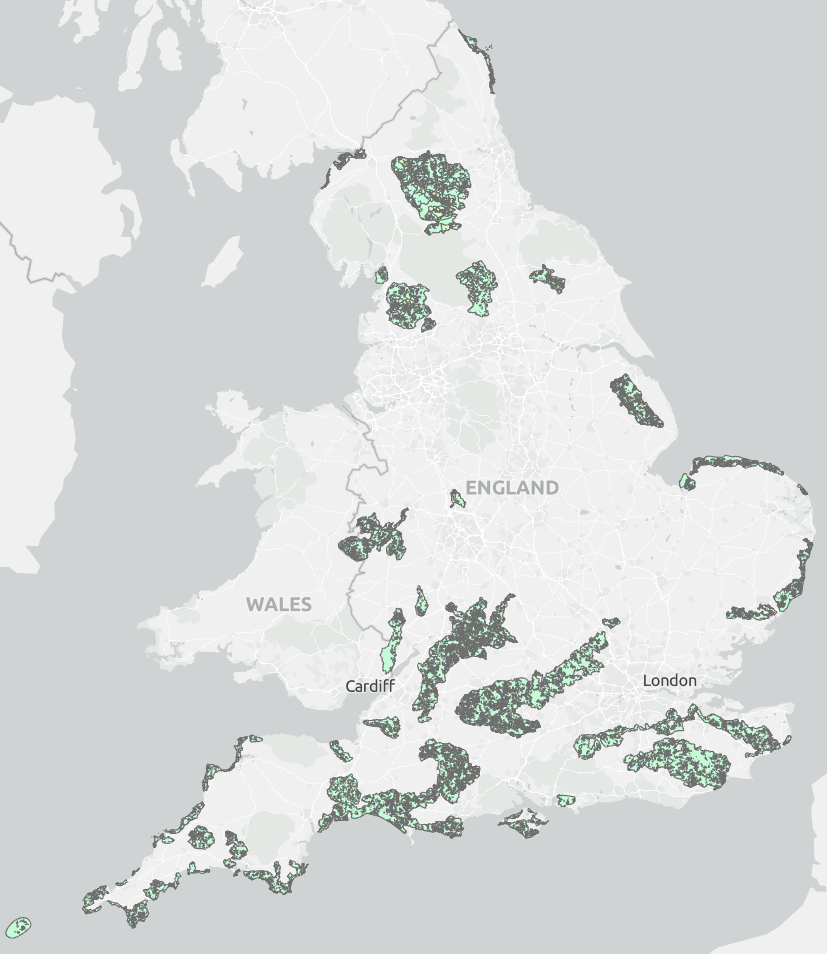


#### What is the area of land in Land Management Schemes in English AONBs?

In [13]:
Total_ES_area = ES_clip_gdf['AREA_CLIP'].sum()
Total_CS_area = CS_clip_gdf['AREA_CLIP'].sum()
print ("The total area of ES in AONBs is", round(Total_ES_area, 2), "sq km", "\nand the total area of CS in AONBs is", round(Total_CS_area, 2), "sq km")

The total area of ES in AONBs is 4509.9 sq km 
and the total area of CS in AONBs is 3102.48 sq km


Lets [pivot](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html#pivot-tables) the data to provide us with some NPE summary statistics

#### Environmental Stewardship area of live agreements sq km

In [20]:
ES_table = pd.pivot_table(ES_clip_gdf, values = 'AREA_CLIP', index = 'NAME', columns = 'APPSTAT', aggfunc=np.sum)
ES_table['AONB_AREA'] = pd.pivot_table(ES_clip_gdf, values = 'STAT_AREA', index = 'NAME')

In [21]:
ES_table

APPSTAT,Live,AONB_AREA
NAME,,
Arnside & Silverdale,10.647989,75.87
Blackdown Hills,33.787985,369.58
Cannock Chase,7.609148,68.65
Chichester Harbour,5.266061,73.16
Chilterns,58.283142,838.30
Cornwall,198.484965,964.03
Cotswolds,538.694961,2041.09
Cranborne Chase & West Wiltshire Downs,237.562329,985.94
Dedham Vale,37.221480,90.58


#### Environmental Stewardship area of live agreements by Scheme Type

In [22]:
pd.pivot_table(ES_clip_gdf, values = 'AREA_CLIP', index = ['NAME'], columns = ['SCHEME'], aggfunc=np.sum)

SCHEME,Entry Level plus Higher Level Stewardship,Higher Level Stewardship,Organic Entry Level plus Higher Level Stewardship
NAME,,,
Arnside & Silverdale,7.392989,3.016392,0.238607
Blackdown Hills,27.804074,4.237680,1.746232
Cannock Chase,3.991272,3.617876,NaN
Chichester Harbour,4.495642,0.770419,NaN
Chilterns,39.485172,7.256155,11.541815
Cornwall,170.653076,15.137943,12.693946
Cotswolds,446.641037,3.236519,88.817404
Cranborne Chase & West Wiltshire Downs,230.312650,0.224697,7.024982
Dedham Vale,37.161634,0.059846,NaN


#### Countryside Stewardship area of live agreements sq km

In [24]:
CS_table = pd.pivot_table(CS_clip_gdf, values = 'AREA_CLIP', index = 'NAME', columns = 'STATUS', aggfunc=np.sum)
CS_table['AONB_AREA'] = pd.pivot_table(CS_clip_gdf, values = 'STAT_AREA', index = 'NAME')
CS_table

STATUS,Agreement Live,AONB_AREA
NAME,,
Arnside & Silverdale,5.253994,75.87
Blackdown Hills,45.243050,369.58
Cannock Chase,28.053032,68.65
Chichester Harbour,3.589281,73.16
Chilterns,145.628080,838.30
Cornwall,106.164625,964.03
Cotswolds,369.899689,2041.09
Cranborne Chase & West Wiltshire Downs,221.745982,985.94
Dedham Vale,12.832158,90.58


#### Countryside Stewardship area of live agreements by Scheme Type

In [25]:
pd.pivot_table(CS_clip_gdf, values = 'AREA_CLIP', index = 'NAME', columns = 'CS_TYPE', aggfunc=np.sum)

CS_TYPE,FEASIBILITY STUDY,FEASIBILITY STUDY AND HISTORIC BUILDING RESTORATION,HEDGEROWS AND BOUNDARIES,Higher Tier,IMPLEMENTATION PLAN,Mid Tier,TREE HEALTH IMPROVEMENT,TREE HEALTH RESTORATION,WOODLAND MANAGEMENT PLAN
NAME,,,,,,,,,
Arnside & Silverdale,NaN,NaN,NaN,3.225082,0.676934,0.778190,NaN,NaN,0.573789
Blackdown Hills,NaN,NaN,NaN,3.330409,0.426556,37.530021,0.298609,0.073196,3.584259
Cannock Chase,0.316111,25.079079,NaN,2.389425,NaN,0.176253,NaN,NaN,0.092164
Chichester Harbour,NaN,NaN,NaN,3.065343,NaN,0.523938,NaN,NaN,NaN
Chilterns,NaN,0.858229,NaN,40.715872,NaN,92.035666,NaN,0.990993,11.027319
Cornwall,NaN,NaN,NaN,24.312484,NaN,78.007653,0.044340,0.409544,3.390604
Cotswolds,NaN,0.049496,2.477482,88.988708,NaN,243.415338,NaN,1.038080,33.930584
Cranborne Chase & West Wiltshire Downs,NaN,NaN,NaN,94.349360,12.333362,106.608648,2.038183,4.462422,1.954008
Dedham Vale,NaN,NaN,NaN,4.343647,NaN,5.837740,NaN,0.021440,2.629331


## By year, what is the area of land by which Land Management Schemes will be ending?

#### Environmental Stewardship area of live agreements ending by year

In [26]:
pd.pivot_table(ES_clip_gdf, values = 'AREA_CLIP', index = ['NAME'], columns = ['END_YEAR'], aggfunc=np.sum)

END_YEAR,2020,2021,2022,2023,2024,2029
NAME,,,,,,
Arnside & Silverdale,4.519348,2.187308,0.472368,3.468964,NaN,NaN
Blackdown Hills,4.728809,15.361671,4.052189,4.025782,5.619534,NaN
Cannock Chase,0.214784,1.809913,4.576878,1.007573,NaN,NaN
Chichester Harbour,4.285588,0.210054,0.770419,NaN,NaN,NaN
Chilterns,10.742957,20.760350,22.321901,3.225010,1.232925,NaN
Cornwall,35.717285,56.890314,44.135165,41.141003,20.601198,NaN
Cotswolds,73.341556,188.867310,86.771306,95.174942,94.539847,NaN
Cranborne Chase & West Wiltshire Downs,51.977645,119.983464,23.556350,38.358794,3.686075,NaN
Dedham Vale,7.404277,7.833626,1.961418,13.146211,6.875949,NaN


#### Countryside Stewardship area of live agreements ending by year

In [27]:
pd.pivot_table(CS_clip_gdf, values = 'AREA_CLIP', index = ['NAME'], columns = ['END_YEAR'], aggfunc=np.sum)

END_YEAR,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
NAME,,,,,,,,,,,,,
Arnside & Silverdale,NaN,NaN,0.008414,0.685200,1.720528,0.735615,2.104236,NaN,NaN,NaN,NaN,NaN,NaN
Blackdown Hills,NaN,0.117163,0.443247,4.560922,10.099269,4.812207,14.128495,9.407619,0.104696,0.922875,0.081916,NaN,0.564641
Cannock Chase,NaN,NaN,0.408275,25.079079,NaN,0.589734,1.269562,NaN,0.706382,NaN,NaN,NaN,NaN
Chichester Harbour,NaN,NaN,NaN,1.988184,0.523938,0.344386,NaN,NaN,NaN,0.732773,NaN,NaN,NaN
Chilterns,NaN,NaN,2.768330,22.648225,29.444500,32.369416,40.601301,14.957897,NaN,2.286688,0.123763,NaN,0.427960
Cornwall,NaN,NaN,0.016196,13.109679,15.092823,32.813591,29.912438,8.569278,0.675993,1.701203,1.492306,2.503263,0.277854
Cotswolds,NaN,0.994302,7.017746,53.025629,88.751490,69.641349,76.391427,43.479170,5.181991,6.565771,10.324231,7.871642,0.654941
Cranborne Chase & West Wiltshire Downs,NaN,0.030087,12.996300,23.795209,38.136382,34.883628,48.726753,13.327611,2.736360,11.625302,21.175141,14.005665,0.307545
Dedham Vale,NaN,NaN,NaN,2.212288,1.734624,1.296974,1.454736,2.688535,NaN,3.445001,NaN,NaN,NaN
